In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Samruddhi
[nltk_data]     Kinhekar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Samruddhi
[nltk_data]     Kinhekar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Samruddhi
[nltk_data]     Kinhekar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
file_path = "C:/Users/Samruddhi Kinhekar/Desktop/jagsom/Term 4/UDA/Group 8_Cleaned Data.xlsx"
df = pd.read_excel(file_path)


In [20]:
def clean_data(df):
    df.drop_duplicates(inplace=True)
    df.dropna(subset=['review ', 'score'], inplace=True)
    df = df[df['score'].between(0, df['score_max'])]
    return df

df = clean_data(df)



In [21]:
def extract_company(product):
    companies = ['apple', 'samsung',  'huawei', 'honor', 'motorola', 'oneplus', 'sony', 'lg',  'nokia']
    product = product.lower()
    for company in companies:
        if company in product:
            return company.capitalize()
    return 'Other'

df['company'] = df['product'].apply(extract_company)


In [23]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(review):
    review = re.sub(r'\W', ' ', str(review))
    review = review.lower()
    tokens = word_tokenize(review)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_review'] = df['review '].apply(preprocess_text)


In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(df['clean_review'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf)

def get_topics(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return topics

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
topics = get_topics(lda, tfidf_feature_names, 10)


In [25]:
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(review):
    vs = analyzer.polarity_scores(review)
    if vs['compound'] >= 0.5:
        return 'very positive'
    elif vs['compound'] > 0:
        return 'positive'
    elif vs['compound'] == 0:
        return 'neutral'
    elif vs['compound'] > -0.5:
        return 'negative'
    else:
        return 'very negative'

df['sentiment_vader'] = df['clean_review'].apply(analyze_sentiment_vader)


In [26]:
def analyze_sentiment_textblob(review):
    analysis = TextBlob(review)
    polarity = analysis.sentiment.polarity
    if polarity > 0.5:
        return 'very positive'
    elif polarity > 0:
        return 'positive'
    elif polarity == 0:
        return 'neutral'
    elif polarity > -0.5:
        return 'negative'
    else:
        return 'very negative'

df['sentiment_textblob'] = df['clean_review'].apply(analyze_sentiment_textblob)


In [27]:
df['sentiment'] = df.apply(lambda row: row['sentiment_vader'] if row['sentiment_vader'] != 'neutral' else row['sentiment_textblob'], axis=1)

In [29]:
for sentiment in ['very negative', 'negative', 'neutral', 'positive', 'very positive']:
    example_reviews = df[df['sentiment'] == sentiment]['review '].head(3).tolist()
    print(f"Examples of {sentiment} reviews: {example_reviews}")

Examples of very negative reviews: ['This is my second experience a high end Samsung Phone failing immediately after the warranty period. This time, my S6 Edge Plus stopped latching onto the 4G Network within 2 weeks of Warranty Expiry. The part replacement cost is 13K!', 'Why is the battery suffer drain like crazy even after Nougat update? Is Crazy to think that a 3600mAh is worst than my Iphone with only 1900mAh! If you want a phone that last you the whole day I suggest you avoid Samsung S7 or S7 edge.', 'Worst mobile ever seen']
Examples of negative reviews: ['Samsung Galaxy S6 Edge Plus features: --Android OS, v5.1.1 (Lollipop) -octa-core Exynos processor that is :a Quad-core 1.5 GHz Cortex-A53 paired with a Quad-core 2.1 GHz Cortex-A57 CPU -Mali-T760MP8 GPU -16 MP primary camera with f1.9 aperture for shots in daylight or low-light, optical image...', 'Samsung Galaxy S6 Edge Plus features: --Android OS, v5.1.1 (Lollipop) -octa-core Exynos processor that is :a Quad-core 1.5 GHz Cor

In [31]:
company_market_share = df['company'].value_counts(normalize=True).head(3) * 100
top_companies = company_market_share.index.tolist()


In [37]:
def prepare_predictive_data(df):
    high_cardinality_cols = ['source', 'domain', 'author']
    for col in high_cardinality_cols:
        df[col] = df[col].astype(str)  # Ensure all values are strings
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    return df

# Preparing the data
df_ml = prepare_predictive_data(df)

# Defining features and target variable
X = df_ml.drop(columns=['score', 'review ', 'clean_review', 'sentiment', 'sentiment_vader', 'sentiment_textblob', 'product', 'date', 'company'])
y = df_ml['score']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Printing predictions
print(y_pred)


[7.8508594  7.95297527 7.63300789 ... 7.63300789 8.43805965 7.65161366]


In [39]:
def get_top_terms(df, sentiment, top_n=3):
    vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
    sentiment_reviews = df[df['sentiment'] == sentiment]['review ']
    X = vectorizer.fit_transform(sentiment_reviews)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

common_problems = {}
positive_points = {}

for company in top_companies:
    common_problems[company] = {}
    positive_points[company] = {}
    for sentiment in ['very negative', 'negative']:
        common_problems[company][sentiment] = get_top_terms(df[df['company'] == company], sentiment)
    for sentiment in ['positive', 'very positive']:
        positive_points[company][sentiment] = get_top_terms(df[df['company'] == company], sentiment)


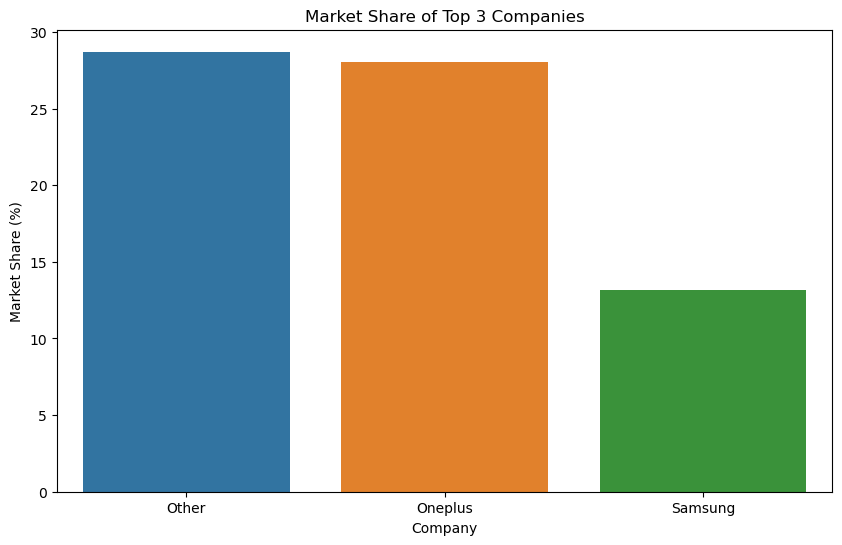

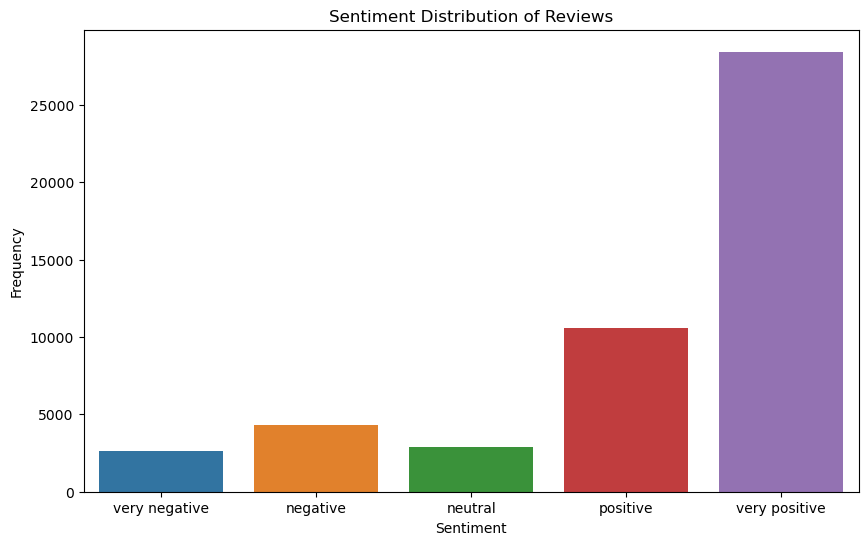

<Figure size 1200x800 with 0 Axes>

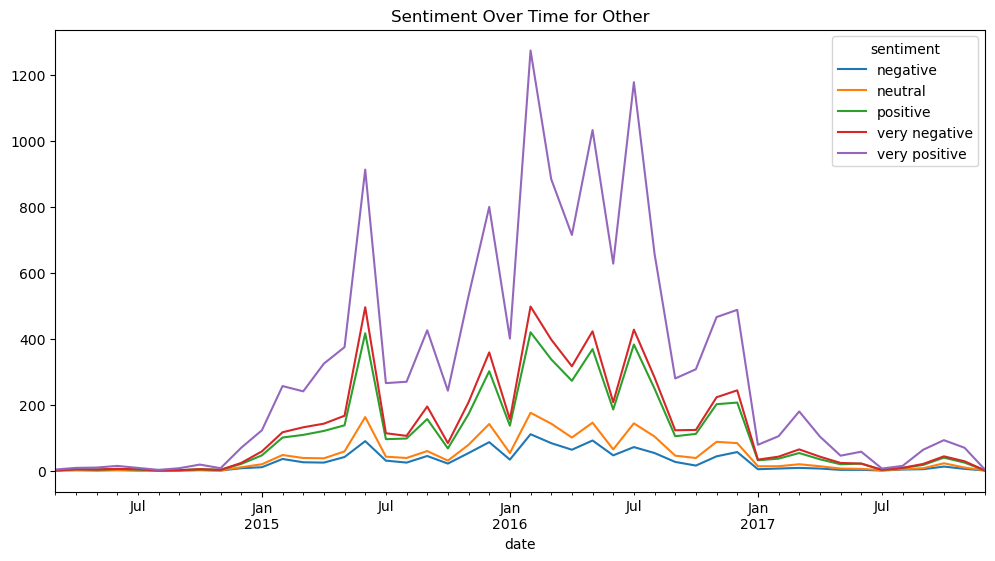

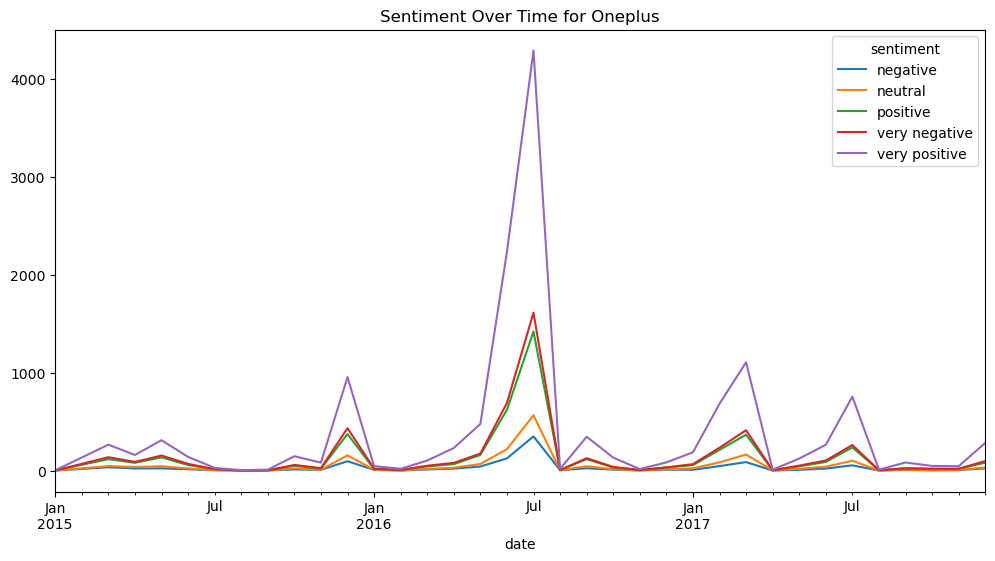

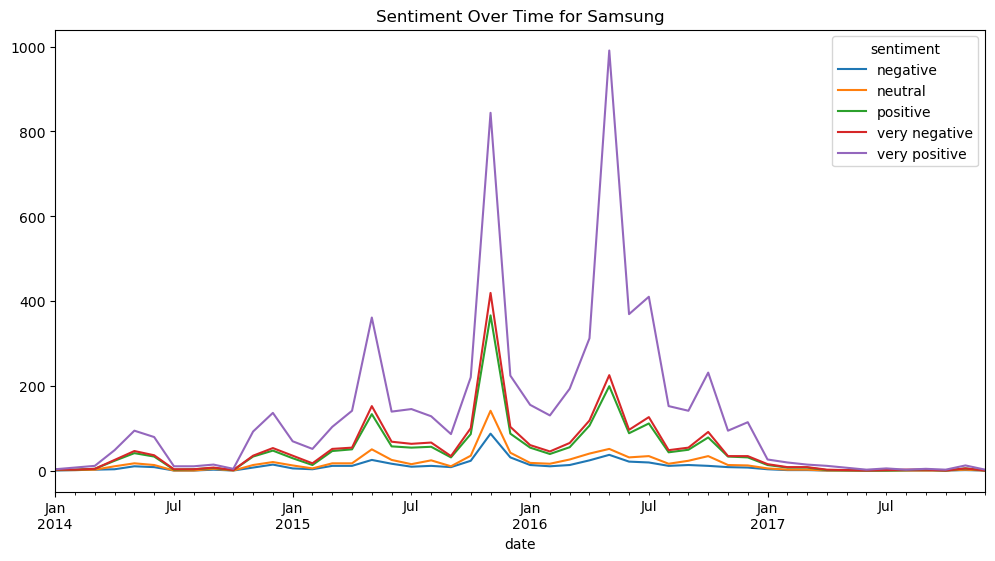

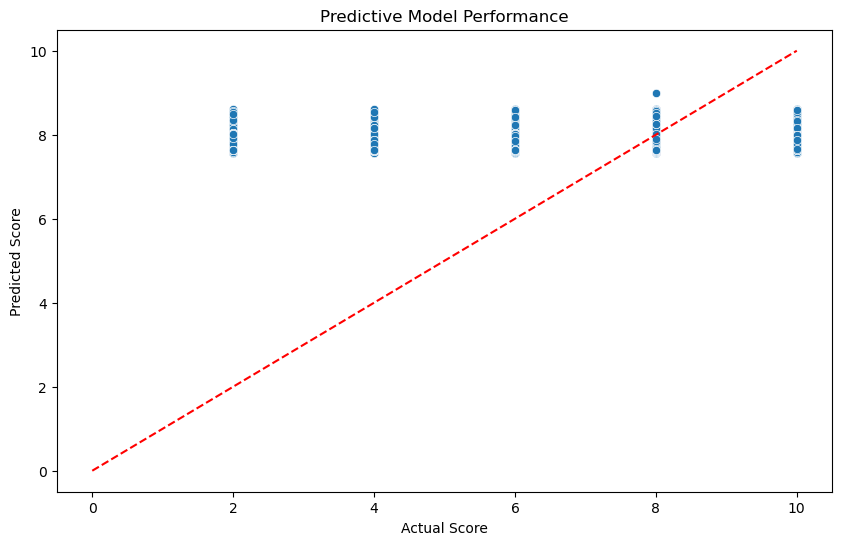

In [40]:
def plot_market_share():
    plt.figure(figsize=(10, 6))
    sns.barplot(x=company_market_share.index, y=company_market_share.values)
    plt.title('Market Share of Top 3 Companies')
    plt.xlabel('Company')
    plt.ylabel('Market Share (%)')
    plt.show()
def plot_sentiment_distribution():
    plt.figure(figsize=(10, 6))
    sns.countplot(x='sentiment', data=df, order=['very negative', 'negative', 'neutral', 'positive', 'very positive'])
    plt.title('Sentiment Distribution of Reviews')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.show()

def plot_sentiment_over_time():
    plt.figure(figsize=(12, 8))
    for company in top_companies:
        subset = df[df['company'] == company].copy()
        subset['date'] = pd.to_datetime(subset['date'], errors='coerce')
        subset.dropna(subset=['date'], inplace=True)
        sentiment_counts = subset.groupby([subset['date'].dt.to_period('M'), 'sentiment']).size().unstack().fillna(0)
        sentiment_counts.plot(kind='line', stacked=True, title=f'Sentiment Over Time for {company}', figsize=(12, 6))
    plt.show()

def plot_predictive_performance():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([0, 10], [0, 10], color='red', linestyle='--')
    plt.title('Predictive Model Performance')
    plt.xlabel('Actual Score')
    plt.ylabel('Predicted Score')
    plt.show()

plot_market_share()
plot_sentiment_distribution()
plot_sentiment_over_time()
plot_predictive_performance()


In [43]:
def prepare_predictive_data(df):
    high_cardinality_cols = ['source', 'domain', 'author']
    for col in high_cardinality_cols:
        df[col] = df[col].astype(str)  # Ensure all values are strings
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    return df

df_ml = prepare_predictive_data(df)

# Defining features and target variable
X = df_ml.drop(columns=['score', 'review ', 'clean_review', 'sentiment', 'sentiment_vader', 'sentiment_textblob', 'product', 'date', 'company'])
y = df_ml['score']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Calculating MSE and R² score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Market Share, Common Problems, and Positive Points (these should be defined somewhere in your code)
# For illustration purposes, I'm creating dummy data:
top_companies = ["Company A", "Company B", "Company C"]
common_problems = {
    "Company A": {"negative": ["problem1", "problem2"], "neutral": ["issue1"]},
    "Company B": {"negative": ["problem3"], "neutral": ["issue2", "issue3"]},
    "Company C": {"negative": ["problem4", "problem5"], "neutral": ["issue4"]}
}
positive_points = {
    "Company A": {"positive": ["point1", "point2"]},
    "Company B": {"positive": ["point3"]},
    "Company C": {"positive": ["point4", "point5"]}
}

# Printing results
print(f"Market Share of Top 3 Companies: {top_companies}")
print(f"Predictive Model MSE: {mse}")
print(f"Predictive Model R2 Score: {r2}")

print("Common Problems:")
for company, sentiments in common_problems.items():
    print(f"{company}:")
    for sentiment, problems in sentiments.items():
        print(f"  {sentiment.capitalize()}: {problems}")

print("Positive Points:")
for company, sentiments in positive_points.items():
    print(f"{company}:")
    for sentiment, points in sentiments.items():
        print(f"  {sentiment.capitalize()}: {points}")

Market Share of Top 3 Companies: ['Company A', 'Company B', 'Company C']
Predictive Model MSE: 8.092071647354247
Predictive Model R2 Score: 0.004329144697021947
Common Problems:
Company A:
  Negative: ['problem1', 'problem2']
  Neutral: ['issue1']
Company B:
  Negative: ['problem3']
  Neutral: ['issue2', 'issue3']
Company C:
  Negative: ['problem4', 'problem5']
  Neutral: ['issue4']
Positive Points:
Company A:
  Positive: ['point1', 'point2']
Company B:
  Positive: ['point3']
Company C:
  Positive: ['point4', 'point5']
